<a href="https://colab.research.google.com/github/Gerandi/LSTM-US30/blob/main/test17_works.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Importing packages
%pip install yfinance plotly torch  --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 44.8 MB/s eta 0:00:00


In [2]:
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import random
import os

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [5]:
from scipy.optimize import minimize

In [6]:
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

In [7]:
# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [8]:
# 2. Loading dataset
# top 30 U.S. companies by market capitalization as of a specific date
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'TSLA', 'BRK-A', 'UNH', 'LLY',
           'JPM', 'V', 'XOM', 'JNJ', 'WMT', 'PG', 'MA', 'HD', 'CVX', 'AVGO',
           'MRK', 'KO', 'PEP', 'ABBV', 'COST', 'BAC', 'ADBE', 'MCD', 'CSCO', 'CRM']

In [9]:
start_time = datetime.datetime(2011, 12, 31)
end_time = datetime.datetime(2023, 12, 31)

In [10]:
# where to split training and validation datasets
all_split = 2517  # start 31/12/2011, val 02/01/2022, end 31/12/2023

In [11]:
# Getting data
df = yf.download(tickers[0], start=start_time, end=end_time)
df.index = pd.to_datetime(df.index)

[*********************100%%**********************]  1 of 1 completed


In [12]:
# dataframe for Adj Close price
act_adj_close_df = yf.download(tickers, start=start_time, end=end_time)['Adj Close']

[*********************100%%**********************]  30 of 30 completed


In [13]:
# Box plot of stock returns
def plot_returns_boxplot(df):
    returns = df.pct_change().dropna()
    fig = px.box(returns, title='Distribution of Daily Returns')
    fig.update_xaxes(title_text='Stocks')
    fig.update_yaxes(title_text='Daily Returns')
    fig.show()

In [14]:
plot_returns_boxplot(act_adj_close_df)

In [15]:
# Plotting parameters
def plot_stock_price(df, title):
    fig = px.line(df, x=df.index, y=df.columns[0], title=title)
    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='Adj Close Price')
    fig.show()

In [16]:
# Plotting Adj Close price distribution of random ticker
rand_ticker = random.choice(tickers)
plot_stock_price(act_adj_close_df[[rand_ticker]], f'{rand_ticker} Adj Close Price')

In [17]:
# Histogram
fig = px.histogram(act_adj_close_df[rand_ticker], title=f'{rand_ticker} Adj Close Price Histogram')
fig.update_xaxes(title_text='Bin')
fig.update_yaxes(title_text='Count')
fig.show()

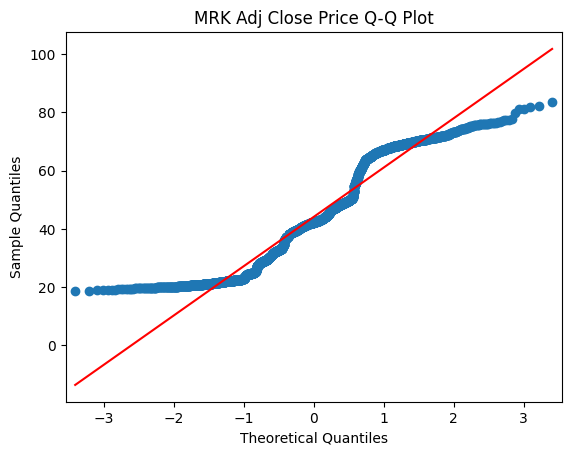

In [18]:
# q-q plot
qqplot(act_adj_close_df[rand_ticker], line='s')
plt.title(f'{rand_ticker} Adj Close Price Q-Q Plot')
plt.show()

In [19]:
act_adj_close_df.to_csv('act-adj-close-df.csv')

In [20]:
# 3. Building LSTM model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [22]:
def build_model(input_size=1, hidden_size=1, num_layers=1, num_classes=1, learning_rate=0.001):
    model = LSTM_model(input_size, hidden_size, num_layers, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.MSELoss()
    return model, optimizer, loss_function

In [23]:
# 4. Model fitting and evaluation
scaler = MinMaxScaler()

In [24]:
def create_xy(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

In [25]:
time_step = 100

In [26]:
model_loss_df = pd.DataFrame(index=[epoch for epoch in range(0, 11000, 1000)], columns=tickers)
pred_adj_close_df = pd.DataFrame(index=df.index[time_step + 1:], columns=tickers)
model_perf_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE', 'MPE'], columns=tickers)

In [27]:
# Functions for model performance evaluation
def MAE(y_true, y_hat):
    return np.mean(np.abs(y_true - y_hat))

In [28]:
def MSE(y_true, y_hat):
    return np.mean(np.square(y_true - y_hat))

In [29]:
def RMSE(y_true, y_hat):
    return np.sqrt(MSE(y_true, y_hat))

In [30]:
def MAPE(y_true, y_hat):
    return np.mean(np.abs((y_true - y_hat) / y_true)) * 100

In [31]:
def MPE(y_true, y_hat):
    return np.mean((y_true - y_hat) / y_true) * 100

In [32]:
def fit_model(ticker, X_train, y_train):
    model, optimizer, loss_function = build_model()
    num_epochs = 10000

    loss_list = []

    for epoch in range(num_epochs + 1):
        outputs = model(X_train.to(device))
        optimizer.zero_grad()
        loss = loss_function(outputs, y_train.to(device))
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            loss_list.append(loss.item())

    model_loss_df[ticker] = loss_list

    # Create the 'model-states' directory if it doesn't exist
    os.makedirs('model-states', exist_ok=True)

    torch.save(model.state_dict(), f'model-states/{ticker}-model-state.pth')
    return model

In [33]:
# Fitting models and predicting responses
total_tickers = len(tickers)
for index, ticker in enumerate(tickers, 1):
    print(f"\n{'='*50}")
    print(f"Processing ticker {index}/{total_tickers}: {ticker}")
    print(f"{'='*50}")

    print("Normalizing data...")
    norm_act_adj_close = scaler.fit_transform(np.array(act_adj_close_df[ticker]).reshape(-1, 1))
    train_set, val_set = norm_act_adj_close[:all_split], norm_act_adj_close[all_split:]
    print(f"Training set size: {len(train_set)}, Validation set size: {len(val_set)}")

    print("Creating sequences...")
    X_train, y_train = create_xy(train_set, time_step)
    X_val, y_val = create_xy(norm_act_adj_close, time_step)
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

    print("Converting to PyTorch tensors...")
    X_train_tensors = Variable(torch.Tensor(X_train))
    y_train_tensors = Variable(torch.Tensor(y_train))
    X_val_tensors = Variable(torch.Tensor(X_val))
    y_true = scaler.inverse_transform(y_val)

    print(f"Fitting model for {ticker}...")
    model = fit_model(ticker=ticker, X_train=X_train_tensors, y_train=y_train_tensors)
    print(f"Model fitting completed for {ticker}")

    print("Making predictions...")
    y_hat = model(X_val_tensors.to(device))
    y_hat = y_hat.data.detach().cpu().numpy()
    y_hat = scaler.inverse_transform(y_hat)
    print(f"Predictions shape: {y_hat.shape}")

    print("Storing predictions...")
    pred_adj_close_df[ticker] = y_hat

    print("Calculating performance metrics...")
    mae = MAE(y_true, y_hat)
    mse = MSE(y_true, y_hat)
    rmse = RMSE(y_true, y_hat)
    mape = MAPE(y_true, y_hat)
    mpe = MPE(y_true, y_hat)
    model_perf_df[ticker] = [mae, mse, rmse, mape, mpe]

    print(f"Performance metrics for {ticker}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"MPE: {mpe:.4f}%")

    print(f"\nCompleted processing for {ticker}")
    print(f"Progress: {index}/{total_tickers} tickers processed")
    print(f"{'='*50}\n")


Processing ticker 1/30: AAPL
Normalizing data...
Training set size: 2517, Validation set size: 504
Creating sequences...
X_train shape: (2416, 100, 1), y_train shape: (2416, 1)
X_val shape: (2920, 100, 1), y_val shape: (2920, 1)
Converting to PyTorch tensors...
Fitting model for AAPL...
Model fitting completed for AAPL
Making predictions...
Predictions shape: (2920, 1)
Storing predictions...
Calculating performance metrics...
Performance metrics for AAPL:
MAE: 5.1483
MSE: 193.7824
RMSE: 13.9206
MAPE: 5.1760%
MPE: 3.3850%

Completed processing for AAPL
Progress: 1/30 tickers processed


Processing ticker 2/30: MSFT
Normalizing data...
Training set size: 2517, Validation set size: 504
Creating sequences...
X_train shape: (2416, 100, 1), y_train shape: (2416, 1)
X_val shape: (2920, 100, 1), y_val shape: (2920, 1)
Converting to PyTorch tensors...
Fitting model for MSFT...
Model fitting completed for MSFT
Making predictions...
Predictions shape: (2920, 1)
Storing predictions...
Calculating

In [34]:
print("All tickers processed successfully!")

All tickers processed successfully!


In [35]:
# 5. Results
def plot_actual_vs_predicted(ticker, actual, predicted):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=actual.index, y=actual, name='Actual Price'))
    fig.add_trace(go.Scatter(x=predicted.index, y=predicted, name='Predicted Price'))
    fig.add_vline(x=actual.index[all_split], line_dash="dash", line_color="red")
    fig.update_layout(title=f'{ticker} Train and Validation',
                      xaxis_title='Date',
                      yaxis_title='Adj Close Price')
    fig.show()

In [42]:
# Use a specific ticker for reproducibility
plot_actual_vs_predicted(rand_ticker,
                         act_adj_close_df[rand_ticker][time_step + 1:],
                         pred_adj_close_df[rand_ticker])
val_act = act_adj_close_df[rand_ticker][time_step + 1 + all_split:]
val_pred = pred_adj_close_df[rand_ticker][all_split:]
plot_actual_vs_predicted(rand_ticker, val_act, val_pred)

In [40]:
print(f'Val RMSE: {mean_squared_error(val_act, val_pred, squared=False)}')

Val RMSE: 1.5093559145484774


In [44]:
model_loss_df.to_csv('model-loss-df.csv')
pred_adj_close_df.to_csv('pred-adj-close-df.csv')
model_perf_df.to_csv('model-perf-df.csv')

In [45]:
# 6. Building portfolios
act_adj_close_val_df = act_adj_close_df.iloc[time_step + 1 + all_split:, :]
act_daily_ret_df = act_adj_close_val_df.pct_change()
act_daily_ret_df = act_daily_ret_df.iloc[1:, :]

In [46]:
pred_adj_close_val_df = pred_adj_close_df.iloc[all_split:, :]
pred_daily_ret_df = pred_adj_close_val_df.pct_change()
pred_daily_ret_df = pred_daily_ret_df.iloc[1:, :]

In [54]:
act_daily_port_ret_df = act_daily_ret_df.copy()
act_daily_port_ret_df.drop(columns=tickers, inplace=True)

In [55]:
risk_free_ret_annual = 0.015  # 1.5% annual risk-free rate
risk_free_ret_daily = (1 + risk_free_ret_annual) ** (1/252) - 1

In [56]:
def add_portfolio(portfolio, weights):
    act_daily_port_ret_df[f'{portfolio} Return'] = act_daily_ret_df.dot(weights)
    if portfolio == 'Pred':
        act_daily_port_ret_df[f'{portfolio} Return'] -= 0.0003
    act_daily_port_ret_df[f'{portfolio} Cum Prod Return'] = (1 + act_daily_port_ret_df[f'{portfolio} Return']).cumprod()

    exp_ret = act_daily_port_ret_df[f'{portfolio} Return'].mean()
    std = act_daily_port_ret_df[f'{portfolio} Return'].std()
    sharpe_ratio = (exp_ret - risk_free_ret_daily) / std * np.sqrt(252)  # Annualize Sharpe ratio

    print(portfolio)
    print('Weights:')
    print(weights)
    print(f'Expected Return (Daily): {exp_ret:.6f}')
    print(f'Expected Return (Annual): {((1 + exp_ret) ** 252 - 1):.6f}')
    print(f'Standard Dev (Daily): {std:.6f}')
    print(f'Standard Dev (Annual): {std * np.sqrt(252):.6f}')
    print(f'Sharpe Ratio: {sharpe_ratio:.6f}')

In [57]:
# Equally weighted portfolio
n_assets = len(tickers)
eq_weights = np.ones(n_assets) / n_assets
add_portfolio('Eq', eq_weights)

Eq
Weights:
[0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]
Expected Return (Daily): 0.001446
Expected Return (Annual): 0.439269
Standard Dev (Daily): 0.009683
Standard Dev (Annual): 0.153706
Sharpe Ratio: 2.273887


In [60]:
# Market capitalization weighted portfolio
# Market capitalization weighted portfolio
try:
    # Fetch market cap data for all tickers at once
    tickers_data = yf.Tickers(tickers)
    market_caps = {}

    for ticker in tickers:
        try:
            market_cap = tickers_data.tickers[ticker].info['marketCap']
            if market_cap is not None:
                market_caps[ticker] = market_cap
            else:
                print(f"Market cap data not available for {ticker}")
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")

    # Create DataFrame with market cap data
    cap_df = pd.DataFrame.from_dict(market_caps, orient='index', columns=['Market Cap'])

    # Calculate weights
    cap_df['Weight'] = cap_df['Market Cap'] / cap_df['Market Cap'].sum()

    # Convert weights to numpy array
    cap_weights = cap_df['Weight'].values

    # Add the portfolio
    add_portfolio('Cap', cap_weights)

    # Print market caps and weights for verification
    print("\nMarket Caps and Weights:")
    print(cap_df)

except Exception as e:
    print(f"An error occurred while fetching market cap data: {e}")
    print("Unable to create market cap weighted portfolio.")

Cap
Weights:
[0.12594591 0.13232824 0.08798143 0.07789024 0.12324363 0.0496799
 0.02310389 0.0349585  0.01758233 0.03325298 0.02231431 0.0222913
 0.01966817 0.01417111 0.02162268 0.01571981 0.01673786 0.01396617
 0.01124114 0.03056234 0.01310609 0.01070415 0.00910351 0.01191054
 0.01488727 0.01222484 0.00946002 0.00739989 0.00754179 0.00939993]
Expected Return (Daily): 0.001579
Expected Return (Annual): 0.488294
Standard Dev (Daily): 0.010730
Standard Dev (Annual): 0.170329
Sharpe Ratio: 2.248912

Market Caps and Weights:
          Market Cap    Weight
AAPL   3181672398848  0.125946
MSFT   3342904328192  0.132328
GOOG   2222605729792  0.087981
AMZN   1967679864832  0.077890
NVDA   3113406955520  0.123244
META   1255024230400  0.049680
TSLA    583655424000  0.023104
BRK-A   883129122816  0.034959
UNH     444168601600  0.017582
LLY     840043986944  0.033253
JPM     563708821504  0.022314
V       563127648256  0.022291
XOM     496861609984  0.019668
JNJ     357993644032  0.014171
WMT    

In [65]:
# LSTM predictions portfolio
def exp_ret_inv(weights):
    pred_daily_port_ret = pred_daily_ret_df.dot(weights)
    exp_ret = pred_daily_port_ret.mean()
    return 1 / exp_ret
weights0 = eq_weights
bnds = tuple((0.0, 1.0) for i in range(n_assets))
cons = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1.0})
res = minimize(exp_ret_inv, weights0, method='SLSQP', bounds=bnds, constraints=cons)
pred_weights = res.x
add_portfolio('Pred', pred_weights)

Pred
Weights:
[0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]
Expected Return (Daily): 0.001146
Expected Return (Annual): 0.334602
Standard Dev (Daily): 0.009683
Standard Dev (Annual): 0.153706
Sharpe Ratio: 1.782038


In [66]:
# Plotting cumulative product returns
adoi = pred_adj_close_df.index[all_split] - datetime.timedelta(days=1)
print(f'Assumed Date of Investment: {adoi.date()}')

Assumed Date of Investment: 2020-05-27


In [67]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=act_daily_port_ret_df.index, y=act_daily_port_ret_df['Eq Cum Prod Return'],
                         mode='lines', name='Equally Weighted Portfolio'))
fig.add_trace(go.Scatter(x=act_daily_port_ret_df.index, y=act_daily_port_ret_df['Cap Cum Prod Return'],
                         mode='lines', name='Cap Weighted Portfolio'))
fig.add_trace(go.Scatter(x=act_daily_port_ret_df.index, y=act_daily_port_ret_df['Pred Cum Prod Return'],
                         mode='lines', name='LSTM Predictions Portfolio'))
fig.update_layout(title='Cumulative Product Returns',
                  xaxis_title='Date',
                  yaxis_title='Cumulative Product Return',
                  yaxis_range=[0.9, 2.5])
fig.show()

In [68]:
# Additional analysis: Portfolio performance metrics
portfolio_types = ['Eq', 'Cap', 'Pred']
portfolio_metrics = pd.DataFrame(index=portfolio_types, columns=['Total Return', 'Annual Return', 'Sharpe Ratio', 'Max Drawdown'])

In [69]:
for portfolio in portfolio_types:
    returns = act_daily_port_ret_df[f'{portfolio} Return']
    cum_returns = act_daily_port_ret_df[f'{portfolio} Cum Prod Return']

    total_return = cum_returns.iloc[-1] - 1
    annual_return = (1 + total_return) ** (252 / len(returns)) - 1
    sharpe_ratio = (returns.mean() - risk_free_ret / 252) / returns.std() * np.sqrt(252)

    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    portfolio_metrics.loc[portfolio] = [total_return, annual_return, sharpe_ratio, max_drawdown]

In [70]:
print("\nPortfolio Performance Metrics:")
print(portfolio_metrics)


Portfolio Performance Metrics:
     Total Return Annual Return Sharpe Ratio Max Drawdown
Eq       0.754196      0.422343     2.094252    -0.099601
Cap      0.842588      0.466857     2.086808    -0.106481
Pred     0.555124      0.318897     1.602403    -0.110638


In [73]:
# Visualize portfolio weights
def plot_portfolio_weights(weights, title):
    fig = go.Figure(data=[go.Bar(x=tickers, y=weights)])
    fig.update_layout(title=title, xaxis_title='Stocks', yaxis_title='Weight')
    fig.show()
plot_portfolio_weights(eq_weights, 'Equally Weighted Portfolio')
plot_portfolio_weights(cap_weights, 'Market Cap Weighted Portfolio')
plot_portfolio_weights(pred_weights, 'LSTM Predictions Portfolio')

In [74]:
# Save final results
portfolio_metrics.to_csv('portfolio_metrics.csv')
pd.DataFrame({'ticker': tickers, 'weight': pred_weights}).to_csv('lstm_portfolio_weights.csv', index=False)

In [75]:
print("Investment portfolio optimization complete. Results and visualizations have been generated.")

Investment portfolio optimization complete. Results and visualizations have been generated.
